In [20]:
%load_ext autoreload
%autoreload 2
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
os.chdir('../')

In [56]:
from utils.datasets import get_dataloaders, get_img_size, DATASETS
from disvae.utils.modelIO import save_model, load_model, load_metadata


# fit regressor

## load dataset

In [57]:
test_loader = get_dataloaders("ddsprites2",
                              batch_size=128,
                              shuffle=False,
                              logger=None)

## load model

In [58]:
exp_dir = 'cvae_ddsprites2_randSample_klqq=0.1_klu=10_epoch=70_z=7_zu=2'
exp_dir = 'results/' + exp_dir
model = load_model(exp_dir, is_gpu=True)

In [59]:
print(exp_dir)

results/cvae_ddsprites2_randSample_klqq=0.1_klu=10_epoch=70_z=7_zu=2


In [60]:
device = 'cuda'
def infer(model, data):
    with torch.no_grad():
        model.eval()
        device = next(model.parameters()).device

        latents, targets = [], []
        for x, t in data:
            x, xa, xb = x
            x = x.to(device=device)
            xa = xa.to(device=device) 
            xb = xb.to(device=device)

            pmu1, plu1, pmc1, plc1, pmu2, plu2, _, _ = model.encoder(xa, xb)
            post_mean = torch.cat((pmu1, pmc1, pmu2), dim=-1) # just using the mean from xa
            latents.append(post_mean.cpu())
            targets.append(t)

    latents = torch.cat(latents)
    targets = torch.cat(targets)

    return latents, targets

In [61]:
l, t = infer(model, test_loader)

In [73]:
from analysis.metrics import DCIMetrics
metric_data = (l, t)
eastwood = DCIMetrics(metric_data, n_factors=6)


In [74]:
print(t.shape)

torch.Size([737280, 6])


In [75]:
print(l.shape)

torch.Size([737280, 7])


In [76]:
vae_scores = eastwood(model, model_zs = metric_data)


[array([0., 0., 0., 0., 0., 0., 0.]), array([0.        , 0.        , 0.        , 0.37016459, 0.        ,
       0.        , 0.        ]), array([0.00000000e+00, 0.00000000e+00, 1.45349995e-04, 8.43019925e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), array([0.        , 0.01978629, 0.        , 0.        , 0.13418185,
       0.00866528, 0.        ]), array([0.        , 0.95493139, 0.        , 0.        , 0.        ,
       0.        , 0.        ]), array([0.95695269, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 9.56952687e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.97862936e-02
  9.54931386e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.45349995e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.70164593e-01 8.43019925e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.34181

In [77]:
vae_R = vae_scores.R_coeff

## visualizing

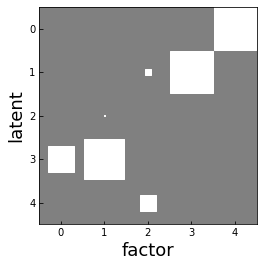

In [83]:
from analysis.hinton import hinton
hinton(vae_R[:5, 1:], 'factor', 'latent', fontsize=18)

In [79]:
print(vae_R.shape)

(7, 6)


In [81]:
print(vae_scores.disentanglement_scores)

[1.         0.94463404 1.         0.65668455 1.         1.
 1.        ]
